<a href="https://colab.research.google.com/github/Xeena2812/deep-learning-nhf/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import image_preprocessing as pre_proc

# Data preprocessing

In this section the data from the ACDC Challenge database is downloaded, extracted and preprocessed to be passed to the network for training. The 4D MRI scans are unrolled into 2D images and padded to be 256 by 256 pixels. Some examples are not fit for preprocessing and they have been thrown away. Then images are downscaled and upsampled to get a 256 by 256 pixels image with a lower resolution.

In [3]:
pre_proc.download_db()

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

In [2]:
pre_proc.extract_files()

FileExistsError: [Errno 17] File exists: 'train_valid'

In [6]:
pre_proc.unroll_scale_images()

patient105.nii done
patient034.nii done
patient015.nii done
patient106.nii done
patient014.nii done
patient029.nii done
patient080.nii done
patient116.nii done
patient098.nii done
patient141.nii done
patient113.nii done
patient149.nii done
patient144.nii done
patient043.nii done
patient131.nii done
patient066.nii done
patient046.nii done
patient097.nii done
patient119.nii done
patient017.nii done
patient103.nii done
patient090.nii done
patient044.nii done
patient094.nii done
patient126.nii done
patient067.nii done
patient069.nii done
patient139.nii done
patient006.nii done
patient059.nii done
patient026.nii done
patient111.nii done
patient051.nii done
patient123.nii done
patient136.nii done
patient054.nii done
patient095.nii done
patient076.nii done
patient128.nii done
patient114.nii done
patient021.nii done
patient096.nii done
patient137.nii done
patient074.nii done
patient077.nii done
patient036.nii done
patient132.nii done
patient062.nii done
patient002.nii done
patient102.nii done


An example with the result of the downscaling on the rgith and the original image on the left.

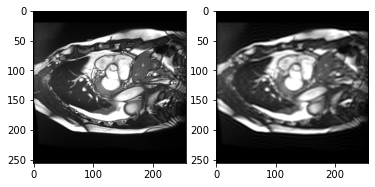

In [7]:
pre_proc.show_example_images()

# Network Structure

For training we used a GAN model, where there are 2 network that work against each other. A generator network tries to generate super resolution (SR) images from the low resolution (LR) images. The other network the Discriminator network tries to differentiate between original high resolution (HR) and SR images. The  discriminator network forces the generator network to create more and more accurate SR images until it can not tell the difference anymore.

## The Generator Network

The generator network consists of convolutional layers followed by some dense layers. Skip connections help the network learn features from different scales. At this point the network structure is only for demonstration and will change a lot in the future.

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import time
import tensorflow as tf
import keras
from keras.models import Model

def make_generator_model():
    y=[]

    input=layers.Input(shape=(64*64,))
    x=layers.Reshape((64,64,1,))(input)
    x=layers.Conv2D(32,(1,1),strides=1,padding='same')(x)

    

    y.append(x)
    x=DenseBlock(x, 4)
    y.append(x)
    x=layers.Concatenate(axis=3)(y)
    
    #x=layers.Conv2D(32,(1,1),strides=1,padding='same')(x)
    #x=DenseBlock(x, 4)
    #y.append(x)
    #x=layers.Concatenate(axis=3)(y)
    
    
    
    
    x=layers.Conv2D(1,(1,1),strides=1,padding='same')(x)
    
    #x=layers.Reshape((64,64,1))(x)

    asd = Model(inputs=input, outputs=x)
    return asd

2022-11-22 14:30:56.593329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 14:30:57.301555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bence/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-22 14:30:57.301587: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 14:30:59.326294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerro

In [3]:
def DenseBlock(x, size):
    skip=[]
    skip.append(x)
    for i in range(0,size) :
        x=ConvBlock(x,(3,3))
        skip.append(x)
        x=layers.Concatenate(axis=3)(skip)
        
        x=ConvBlock(x,(3,3))
        skip.append(x)
        x=layers.Concatenate(axis=3)(skip)
    
    
    return x

In [4]:
def ConvBlock(x,kernel_size) :
    x=layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x=layers.Conv2D(16,kernel_size,strides=1,padding='same')(x)
    x=layers.Conv2D(16,(1,1),strides=1,padding='same')(x)
    x=layers.Dropout(0.3)(x)
    
    return x

## The Discriminator Network

The discriminator network is a convolutional network which will also change a lot in the future. To help the problem of vanishing gradient which occurs with many networks with many parameters we use dropout layers. The network outputs a positive number if it thinks the input iamge is real and a negative if it thinks it's fake.

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=1, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=1, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Evaluation

The discriminator's loss funtion is based on how well it can tell that the real image is real and how well it can tell that the fake image is fake. Because these 2 networks work against each other we can measure the success of the generator network by how well it fooled the discriminator network.

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

2022-11-22 14:31:02.839776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-22 14:31:02.839853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bence-virtual-machine): /proc/driver/nvidia/version does not exist
2022-11-22 14:31:02.849180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [8]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 64, 64, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   64          ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                   

                                                                  'dropout[0][0]',                
                                                                  'dropout_1[0][0]',              
                                                                  'dropout_2[0][0]',              
                                                                  'dropout_3[0][0]',              
                                                                  'dropout_4[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 64, 64, 112)  448        ['concatenate_4[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 64, 64, 112)  0           ['batch_normalization_5[0][0]']  
          

In [9]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [10]:
tf.random.set_seed(5)
def train_generator(generator, X, Y, X_valid, Y_valid, learning_rate, batch_size, epochs):
  generator.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])
  generator.fit(X,Y,batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(X_valid,Y_valid),shuffle= True)

In [11]:
from numpy.lib.shape_base import split
dataset_size=3000
train_split=0.7
valid_split=0.2
test_split=0.1

startx=32
starty=startx+64

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pre_proc.load_and_transform_data(train_split, valid_split,test_split , dataset_size)

EPOCHS = 1
noise_dim = 64*64
num_examples_to_generate = 1000
BUFFER_SIZE = 600000
BATCH_SIZE = 2

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

X_valid=np.reshape(np.asarray(X_valid)[:,startx:starty,startx:starty],(int(dataset_size*valid_split),4096))
Y_valid=np.asarray(Y_valid)
Y_valid=Y_valid.reshape((int(dataset_size*valid_split),256,256))
Y_valid=np.reshape(np.asarray(Y_valid)[:,startx:starty,startx:starty],(int(dataset_size*valid_split),64,64))
Y_train=Y_train.reshape((int(dataset_size*train_split),256,256))
y=np.reshape(Y_train[:,startx:starty,startx:starty],(int(dataset_size*train_split),64,64))
x=np.reshape(X_train[:,startx:starty,startx:starty],(int(dataset_size*train_split),4096))

FileNotFoundError: [Errno 2] No such file or directory: './train_valid/downscaled_images/'

In [97]:
y=np.reshape(y,(int(dataset_size*train_split),64,64,1))
x=np.reshape(x,(int(dataset_size*train_split),4096))

In [47]:
Y_valid.mean()

0.13675481

First we only train the generator to try to generate SR images. Training is only done on one 64 by 64 patch as demonstration.

In [135]:
train_generator(generator,x,y,X_valid,Y_valid,0.0001,2,100)

Epoch 1/100
1050/1050 - 200s - loss: 0.0968 - accuracy: 0.0489 - val_loss: 0.0072 - val_accuracy: 0.0568 - 200s/epoch - 190ms/step
Epoch 2/100
1050/1050 - 208s - loss: 0.0220 - accuracy: 0.0519 - val_loss: 0.0066 - val_accuracy: 0.0568 - 208s/epoch - 198ms/step
Epoch 3/100
1050/1050 - 210s - loss: 0.0120 - accuracy: 0.0527 - val_loss: 0.0061 - val_accuracy: 0.0568 - 210s/epoch - 200ms/step
Epoch 4/100
1050/1050 - 212s - loss: 0.0083 - accuracy: 0.0530 - val_loss: 0.0055 - val_accuracy: 0.0568 - 212s/epoch - 202ms/step
Epoch 5/100
1050/1050 - 213s - loss: 0.0064 - accuracy: 0.0531 - val_loss: 0.0063 - val_accuracy: 0.0568 - 213s/epoch - 203ms/step
Epoch 6/100
1050/1050 - 214s - loss: 0.0052 - accuracy: 0.0531 - val_loss: 0.0058 - val_accuracy: 0.0568 - 214s/epoch - 203ms/step
Epoch 7/100
1050/1050 - 213s - loss: 0.0047 - accuracy: 0.0531 - val_loss: 0.0048 - val_accuracy: 0.0568 - 213s/epoch - 203ms/step
Epoch 8/100
1050/1050 - 212s - loss: 0.0042 - accuracy: 0.0531 - val_loss: 0.0043 -

KeyboardInterrupt: 

In [13]:
import math
mse = tf.keras.losses.MeanSquaredError()
def PSNR(upscaled, original,max):
    return 10*math.log(max/mse(original, upscaled).numpy())

In [122]:
tf.image.psnr(y[:,:,:],generated_image[:,:,:,0],max_val=1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=12.369028>

In [ ]:
num=4
generated_image = generator(x, training=False)
plt.imsave('generated.png',generated_image[num,:,:,0])
img=plt.imread('generated.png')
plt.imshow(generated_image[num,:,:,:], cmap='gray')
print("Peak Signal-to-Noise Ratio:")
print(PSNR(y[num,:,:],img[:,:,1],1))


In [ ]:
plt.imshow(y[num,:,:], cmap='gray')

In [101]:
generator.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [20]:
from tensorflow import keras
generator=keras.models.load_model('model')

In [71]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(x[0:2,:], training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


In [34]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


In [74]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(y, batch_size=2, epochs=100, callbacks=[cbk])


Epoch 1/100
1400/1400 [==============================] - ETA: 0s - d_loss: 50.9456 - g_loss: -20.3362

AttributeError: module 'keras.preprocessing.image' has no attribute 'array_to_img'

In [70]:
x.shape

(2800, 4096)